In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd
import librosa.display
import soundfile as sf

In [3]:
def display_mfcc(mfcc, sr = 22050):
#     mfcc = mfcc.numpy()
    mfcc = mfcc.detach().numpy()
    re_wav = librosa.feature.inverse.mfcc_to_audio(mfcc.T)
    #wav 파형 출력
    librosa.display.waveplot(re_wav, sr=sr, color='r')

In [4]:
class DiabetesDataset(Dataset):
    
    def __init__(self):
#         xy=np.loadtxt('./data/diabetes.csv.gz',delimiter=',',dtype=np.float32)
        x = np.load('최유경_data.npy')
        y = np.load('최유경_label.npy')
        self.len=x.shape[0]
        self.x_data=torch.from_numpy(x).float()
        self.y_data=torch.from_numpy(y).view(-1, 1).float()
        
        
    def __getitem__(self,index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    

In [5]:
batch_size = 32

dataset = DiabetesDataset()

train_loader = DataLoader(dataset = dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0)

tensor([[-1.4770, -0.9929, -0.5983,  ..., -0.7322, -1.6319,  1.0504],
        [-2.1094, -0.3274,  1.3188,  ..., -0.9048,  1.8979,  0.1059],
        [-0.1584,  0.3659, -0.4919,  ..., -1.5321, -0.8534, -0.1283],
        ...,
        [-1.5011, -0.3286, -0.5219,  ...,  1.4597, -0.7104,  0.4949],
        [-0.3598,  1.2213,  2.3255,  ...,  0.9926, -0.2063,  1.1672],
        [-1.3891, -0.1652,  1.4183,  ..., -0.5682,  0.9339, -0.6422]])
torch.Size([32, 100])
torch.Size([32, 45])


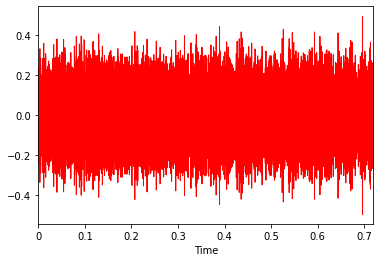

In [6]:
d_noise  = 100
d_hidden = 256

def sample_z(batch_size = 32, d_noise=100):
    return torch.randn(batch_size, d_noise)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 45),
    nn.Tanh()
)

# 노이즈 생성하기
z = sample_z()
print(z)
print(z.shape)
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,45)

print(img_fake.shape)
display_mfcc(img_fake)


In [7]:
D = nn.Sequential(
    nn.Linear(45, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([32, 45])
torch.Size([32, 1])
tensor([[0.5011, 0.4986, 0.5059, 0.5026, 0.5007]],
       grad_fn=<TransposeBackward0>)


In [11]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for i, data in enumerate(train_loader):
        img_batch, label_batch = data
#         img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 45))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        if loss_real.size() != loss_fake.size():
            continue
        loss_d    = (loss_real + loss_fake).mean()
        
        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        
        
        # init optimizer
        _optimizer_g.zero_grad()
        
        

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
                
        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean() 

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
       # Update parameters
        _optimizer_g.step()
        
        
#         if i%10==0:
#             print("z" , generator(sample_z(batch_size, d_noise)).shape)
#             display_mfcc(generator(sample_z(batch_size, d_noise)))
        
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in train_loader:
        
#         img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 45))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
            print("p_real", p_real)
            print("p_fake", p_fake)

    return p_real, p_fake

In [12]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(3):
    
    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)
    
#     display_mfcc(torch.Tensor(G(p_fake)))
#     if((epoch+1)% 50 == 0):
    print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
#         imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

p_real 0.0032
p_fake 2.2268028929829596e-06
p_real 0.0064
p_fake 4.444038309156894e-06
p_real 0.009600000000000001
p_fake 6.666800938546657e-06
p_real 0.0128
p_fake 8.884795568883419e-06
p_real 0.016
p_fake 1.1109523847699165e-05
p_real 0.019200000000000002
p_fake 1.3327394798398017e-05
p_real 0.022400000000000003
p_fake 1.5545250847935676e-05
p_real 0.025600000000000005
p_fake 1.777143198996782e-05
p_real 0.028800000000000006
p_fake 1.999587547034025e-05
p_real 0.03200000000000001
p_fake 2.221439182758331e-05
p_real 0.03520000000000001
p_fake 2.443527095019817e-05
p_real 0.03840000000000001
p_fake 2.665873225778341e-05
p_real 0.04160000000000001
p_fake 2.8895344771444792e-05
p_real 0.04480000000000001
p_fake 3.111180216073989e-05
p_real 0.048000000000000015
p_fake 3.3331924676895135e-05
p_real 0.051200000000000016
p_fake 3.554709050804376e-05
p_real 0.05440000000000002
p_fake 3.776906803250312e-05
p_real 0.05760000000000002
p_fake 3.999057374894618e-05
p_real 0.06080000000000002
p_fak

p_real 0.6591999999999978
p_fake 0.00045790314134210345
p_real 0.6623999999999978
p_fake 0.0004601208105683326
p_real 0.6655999999999977
p_fake 0.0004623442705720663
p_real 0.6687999999999977
p_fake 0.00046456462573260066
p_real 0.6719999999999977
p_fake 0.00046678719911724323
p_real 0.6751999999999977
p_fake 0.00046901087742298833
p_real 0.6783999999999977
p_fake 0.00047122804019600144
p_real 0.6815999999999977
p_fake 0.00047344545144587744
p_real 0.6847999999999976
p_fake 0.00047566882390528905
p_real 0.6879999999999976
p_fake 0.00047790052518248546
p_real 0.6911999999999976
p_fake 0.00048011536691337813
p_real 0.6943999999999976
p_fake 0.00048234696723520743
p_real 0.6975999999999976
p_fake 0.0004845650414004921
p_real 0.7007999999999975
p_fake 0.00048678398188203566
p_real 0.7039999999999975
p_fake 0.0004890103971585631
p_real 0.7071999999999975
p_fake 0.0004912282600998878
p_real 0.7103999999999975
p_fake 0.0004934542309492826
p_real 0.7135999999999975
p_fake 0.0004956671783700585

p_real 1.318400000000005
p_fake 0.0009156922191381457
p_real 1.321600000000005
p_fake 0.0009179170604795221
p_real 1.324800000000005
p_fake 0.0009201275918632749
p_real 1.3280000000000052
p_fake 0.0009223532298579816
p_real 1.3312000000000053
p_fake 0.0009245819192379717
p_real 1.3344000000000054
p_fake 0.0009268088772892956
p_real 1.3376000000000055
p_fake 0.0009290244966745381
p_real 1.3408000000000055
p_fake 0.0009312524581328039
p_real 1.3440000000000056
p_fake 0.0009334696587175135
p_real 1.3472000000000057
p_fake 0.0009356973879039292
p_real 1.3504000000000058
p_fake 0.0009379256006330257
p_real 1.353600000000006
p_fake 0.0009401380367577081
p_real 1.356800000000006
p_fake 0.0009423663984984164
p_real 1.360000000000006
p_fake 0.0009445852441713218
p_real 1.3632000000000062
p_fake 0.0009468190219253306
p_real 1.3664000000000063
p_fake 0.0009490458862856034
p_real 1.3696000000000064
p_fake 0.0009512692406773571
p_real 1.3728000000000065
p_fake 0.000953502164408565
p_real 1.37600000

p_real 1.952000000000023
p_fake 0.0013557589141652007
p_real 1.9552000000000231
p_fake 0.0013579838752746601
p_real 1.9584000000000232
p_fake 0.0013602014906704445
p_real 1.9616000000000233
p_fake 0.0013624228425323983
p_real 1.9648000000000234
p_fake 0.0013646468751132507
p_real 1.9680000000000235
p_fake 0.0013668722707778234
p_real 1.9712000000000236
p_fake 0.0013690937796607633
p_real 1.9744000000000237
p_fake 0.0013713120274245758
p_real 1.9776000000000238
p_fake 0.0013735289813950678
p_real 1.9808000000000239
p_fake 0.0013757452800869962
p_real 1.984000000000024
p_fake 0.0013779668495059033
p_real 1.987200000000024
p_fake 0.0013801851753145477
p_real 1.9904000000000241
p_fake 0.0013824080234393498
p_real 1.9936000000000242
p_fake 0.001384641843661668
p_real 1.9968000000000243
p_fake 0.0013868766259402057
p_real 2.0000000000000244
p_fake 0.0013890981577336808
p_real 2.0032000000000245
p_fake 0.0013913113828748485
p_real 2.0064000000000246
p_fake 0.001393527714535596
p_real 2.009600

p_real 2.6304000000000425
p_fake 0.0018270521489903357
p_real 2.6336000000000426
p_fake 0.0018292815165594247
p_real 2.6368000000000427
p_fake 0.00183150617592037
p_real 2.6400000000000428
p_fake 0.0018337294029071953
p_real 2.643200000000043
p_fake 0.0018359569193795349
p_real 2.646400000000043
p_fake 0.0018381861288100506
p_real 2.649600000000043
p_fake 0.0018404088150709892
p_real 2.652800000000043
p_fake 0.0018426354631781603
p_real 2.656000000000043
p_fake 0.0018448447447270181
p_real 2.6592000000000433
p_fake 0.0018470684651285436
p_real 2.6624000000000434
p_fake 0.0018492916613817242
p_real 2.6656000000000435
p_fake 0.0018515186473727254
p_real 2.6688000000000436
p_fake 0.0018537477254867581
p_real 2.6720000000000437
p_fake 0.0018559719825163511
p_real 2.6752000000000438
p_fake 0.0018581981532275705
p_real 2.678400000000044
p_fake 0.0018604114118963508
p_real 2.681600000000044
p_fake 0.0018626306012272862
p_real 2.684800000000044
p_fake 0.00186485951766372
p_real 2.6880000000000

p_real 3.2576000000000604
p_fake 0.0022627578705549283
p_real 3.2608000000000605
p_fake 0.0022649872368201655
p_real 3.2640000000000606
p_fake 0.0022672107884660403
p_real 3.2672000000000607
p_fake 0.002269431432522837
p_real 3.270400000000061
p_fake 0.0022716481843963305
p_real 3.273600000000061
p_fake 0.0022738650154322426
p_real 3.276800000000061
p_fake 0.002276076774112884
p_real 3.280000000000061
p_fake 0.002278298627771441
p_real 3.283200000000061
p_fake 0.002280534040555362
p_real 3.2864000000000613
p_fake 0.002282762073166672
p_real 3.2896000000000614
p_fake 0.002284979126229886
p_real 3.2928000000000615
p_fake 0.0022871987281367218
p_real 3.2960000000000615
p_fake 0.0022894293548539318
p_real 3.2992000000000616
p_fake 0.002291648507863287
p_real 3.3024000000000617
p_fake 0.002293872538767759
p_real 3.305600000000062
p_fake 0.0022960963005200065
p_real 3.308800000000062
p_fake 0.0022983137873932758
p_real 3.312000000000062
p_fake 0.0023005393302068153
p_real 3.315200000000062
p

p_real 3.907200000000079
p_fake 0.0027139112710952836
p_real 3.910400000000079
p_fake 0.0027161241304129438
p_real 3.9136000000000792
p_fake 0.0027183462252840475
p_real 3.9168000000000793
p_fake 0.002720581205002971
p_real 3.9200000000000794
p_fake 0.0027227991901338173
p_real 3.9232000000000795
p_fake 0.0027250233897939398
p_real 3.9264000000000796
p_fake 0.0027272465014830305
p_real 3.9296000000000797
p_fake 0.0027294659966602994
p_real 3.93280000000008
p_fake 0.0027317000314593387
p_real 3.93600000000008
p_fake 0.002733917872235186
p_real 3.93920000000008
p_fake 0.002736136809922762
p_real 3.94240000000008
p_fake 0.002738352788425989
p_real 3.94560000000008
p_fake 0.0027405737657100033
p_real 3.9488000000000802
p_fake 0.0027428019750863385
p_real 3.9520000000000803
p_fake 0.002745031155832119
p_real 3.9552000000000804
p_fake 0.002747265005297966
p_real 3.9584000000000805
p_fake 0.0027494881823659015
p_real 3.9616000000000806
p_fake 0.0027517137967050147
p_real 3.9648000000000807
p_

p_real 4.550400000000021
p_fake 0.0031607277842238633
p_real 4.553600000000021
p_fake 0.003162950144521901
p_real 4.55680000000002
p_fake 0.0031651749575510708
p_real 4.56000000000002
p_fake 0.0031674056956544606
p_real 4.56320000000002
p_fake 0.0031696310661733238
p_real 4.566400000000019
p_fake 0.003171849090978512
p_real 4.569600000000019
p_fake 0.003174074448645124
p_real 4.572800000000019
p_fake 0.003176299841888258
p_real 4.576000000000018
p_fake 0.0031785282948985786
p_real 4.579200000000018
p_fake 0.003180748803168544
p_real 4.582400000000018
p_fake 0.003182967582531282
p_real 4.585600000000017
p_fake 0.0031851878877729263
p_real 4.588800000000017
p_fake 0.00318741135932506
p_real 4.5920000000000165
p_fake 0.0031896348711103286
p_real 4.595200000000016
p_fake 0.003191862165369102
p_real 4.598400000000016
p_fake 0.0031940755037590945
p_real 4.6016000000000155
p_fake 0.0031962976843118752
p_real 4.604800000000015
p_fake 0.0031985131571069443
p_real 4.608000000000015
p_fake 0.0032

p_real 0.3135999999999999
p_fake 3.917789943516254e-05
p_real 0.31679999999999986
p_fake 3.9577088830992574e-05
p_real 0.31999999999999984
p_fake 3.997657424770295e-05
p_real 0.3231999999999998
p_fake 4.0377396671101446e-05
p_real 0.3263999999999998
p_fake 4.0777068072929976e-05
p_real 0.3295999999999998
p_fake 4.117592135444283e-05
p_real 0.33279999999999976
p_fake 4.157546451315284e-05
p_real 0.33599999999999974
p_fake 4.197350488975644e-05
p_real 0.3391999999999997
p_fake 4.237212399020791e-05
p_real 0.3423999999999997
p_fake 4.277171064168215e-05
p_real 0.3455999999999997
p_fake 4.317174917086959e-05
p_real 0.34879999999999967
p_fake 4.357083570212126e-05
p_real 0.35199999999999965
p_fake 4.396966621279717e-05
p_real 0.3551999999999996
p_fake 4.4367377087473874e-05
p_real 0.3583999999999996
p_fake 4.476682036183775e-05
p_real 0.3615999999999996
p_fake 4.516713782213629e-05
p_real 0.36479999999999957
p_fake 4.55692460294813e-05
p_real 0.36799999999999955
p_fake 4.5970369130373005e-0

p_real 0.8831999999999964
p_fake 0.00011030705100856717
p_real 0.8863999999999964
p_fake 0.00011070619951933619
p_real 0.8895999999999964
p_fake 0.00011110660079866644
p_real 0.8927999999999964
p_fake 0.0001115051740314811
p_real 0.8959999999999964
p_fake 0.00011190418018959459
p_real 0.8991999999999963
p_fake 0.00011230263821780678
p_real 0.9023999999999963
p_fake 0.00011270205718465146
p_real 0.9055999999999963
p_fake 0.00011310149002820249
p_real 0.9087999999999963
p_fake 0.00011350105367600914
p_real 0.9119999999999963
p_fake 0.00011390228169038888
p_real 0.9151999999999962
p_fake 0.00011430259752087291
p_real 0.9183999999999962
p_fake 0.00011470280350185927
p_real 0.9215999999999962
p_fake 0.00011510303216055032
p_real 0.9247999999999962
p_fake 0.0001155010619666427
p_real 0.9279999999999962
p_fake 0.00011589980190619823
p_real 0.9311999999999961
p_fake 0.0001163014643359929
p_real 0.9343999999999961
p_fake 0.00011670070597901936
p_real 0.9375999999999961
p_fake 0.0001171006423886

p_real 1.4560000000000088
p_fake 0.0001818248957395553
p_real 1.459200000000009
p_fake 0.0001822250111959874
p_real 1.462400000000009
p_fake 0.00018262463347055012
p_real 1.4656000000000091
p_fake 0.00018302394137717777
p_real 1.4688000000000092
p_fake 0.00018342357706278557
p_real 1.4720000000000093
p_fake 0.00018382274946197863
p_real 1.4752000000000094
p_fake 0.0001842234290670603
p_real 1.4784000000000095
p_fake 0.00018462360054254527
p_real 1.4816000000000096
p_fake 0.0001850243364460766
p_real 1.4848000000000097
p_fake 0.0001854259209707379
p_real 1.4880000000000098
p_fake 0.00018582748882472512
p_real 1.4912000000000099
p_fake 0.00018622869709506628
p_real 1.49440000000001
p_fake 0.0001866256467066705
p_real 1.49760000000001
p_fake 0.00018702252265065907
p_real 1.5008000000000101
p_fake 0.00018741989517584442
p_real 1.5040000000000102
p_fake 0.00018781840126030146
p_real 1.5072000000000103
p_fake 0.00018821736448444424
p_real 1.5104000000000104
p_fake 0.00018861678545363246
p_re

p_real 2.0288000000000252
p_fake 0.0002533376711886375
p_real 2.0320000000000253
p_fake 0.0002537369183730333
p_real 2.0352000000000254
p_fake 0.00025413772379979477
p_real 2.0384000000000255
p_fake 0.0002545385675504802
p_real 2.0416000000000256
p_fake 0.00025493683489039525
p_real 2.0448000000000257
p_fake 0.00025533773349598033
p_real 2.048000000000026
p_fake 0.000255734496982768
p_real 2.051200000000026
p_fake 0.000256134021328762
p_real 2.054400000000026
p_fake 0.0002565337201114742
p_real 2.057600000000026
p_fake 0.0002569345802068709
p_real 2.060800000000026
p_fake 0.0002573328533209859
p_real 2.0640000000000263
p_fake 0.00025773251862265154
p_real 2.0672000000000263
p_fake 0.00025813201526179893
p_real 2.0704000000000264
p_fake 0.00025853216946125016
p_real 2.0736000000000265
p_fake 0.0002589313625358044
p_real 2.0768000000000266
p_fake 0.00025932953669689584
p_real 2.0800000000000267
p_fake 0.00025972854075953354
p_real 2.083200000000027
p_fake 0.0002601279320195316
p_real 2.0

p_real 2.6624000000000434
p_fake 0.0003324426120147103
p_real 2.6656000000000435
p_fake 0.00033284237338229955
p_real 2.6688000000000436
p_fake 0.0003332390319555992
p_real 2.6720000000000437
p_fake 0.0003336391453165555
p_real 2.6752000000000438
p_fake 0.0003340381166432047
p_real 2.678400000000044
p_fake 0.00033443751209415434
p_real 2.681600000000044
p_fake 0.00033483773465268254
p_real 2.684800000000044
p_fake 0.0003352369620464736
p_real 2.688000000000044
p_fake 0.0003356362733989948
p_real 2.6912000000000442
p_fake 0.0003360355895012611
p_real 2.6944000000000443
p_fake 0.00033643566817045153
p_real 2.6976000000000444
p_fake 0.00033683379418216586
p_real 2.7008000000000445
p_fake 0.0003372333740815514
p_real 2.7040000000000446
p_fake 0.0003376328376121813
p_real 2.7072000000000447
p_fake 0.0003380325418431306
p_real 2.7104000000000448
p_fake 0.000338433714397251
p_real 2.713600000000045
p_fake 0.0003388322473503643
p_real 2.716800000000045
p_fake 0.00033923208150081274
p_real 2.72

p_real 3.3280000000000625
p_fake 0.0004155648488551372
p_real 3.3312000000000626
p_fake 0.000415965270576998
p_real 3.3344000000000626
p_fake 0.0004163645106833422
p_real 3.3376000000000627
p_fake 0.0004167644193395966
p_real 3.340800000000063
p_fake 0.00041716412599198457
p_real 3.344000000000063
p_fake 0.0004175627517979586
p_real 3.347200000000063
p_fake 0.0004179612050298595
p_real 3.350400000000063
p_fake 0.0004183629099279636
p_real 3.353600000000063
p_fake 0.00041876360299065643
p_real 3.3568000000000633
p_fake 0.00041916266852058405
p_real 3.3600000000000634
p_fake 0.00041956178527325326
p_real 3.3632000000000635
p_fake 0.0004199610500596457
p_real 3.3664000000000636
p_fake 0.0004203608782961958
p_real 3.3696000000000637
p_fake 0.0004207611488178366
p_real 3.3728000000000637
p_fake 0.00042116024098358987
p_real 3.376000000000064
p_fake 0.00042156070275232136
p_real 3.379200000000064
p_fake 0.00042195974783971844
p_real 3.382400000000064
p_fake 0.0004223589563742274
p_real 3.385

p_real 3.9872000000000813
p_fake 0.0004979025889188047
p_real 3.9904000000000814
p_fake 0.0004983017054386433
p_real 3.9936000000000815
p_fake 0.0004987018018495288
p_real 3.9968000000000816
p_fake 0.0004991023556329306
p_real 4.000000000000082
p_fake 0.0004995001000817861
p_real 4.003200000000081
p_fake 0.000499900805437937
p_real 4.006400000000081
p_fake 0.0005002996043767776
p_real 4.009600000000081
p_fake 0.0005006969192530956
p_real 4.01280000000008
p_fake 0.000501095325592905
p_real 4.01600000000008
p_fake 0.0005014943725895134
p_real 4.01920000000008
p_fake 0.0005018939683679489
p_real 4.022400000000079
p_fake 0.0005022923706099389
p_real 4.025600000000079
p_fake 0.0005026909070089458
p_real 4.0288000000000785
p_fake 0.000503091855952516
p_real 4.032000000000078
p_fake 0.0005034918668679891
p_real 4.035200000000078
p_fake 0.0005038925610482691
p_real 4.0384000000000775
p_fake 0.0005042908673640339
p_real 4.041600000000077
p_fake 0.0005046905061695723
p_real 4.044800000000077
p_f

p_real 4.614400000000014
p_fake 0.0005762005307711654
p_real 4.617600000000014
p_fake 0.0005766001910436891
p_real 4.620800000000013
p_fake 0.0005770013548899434
p_real 4.624000000000013
p_fake 0.0005774015076924107
p_real 4.627200000000013
p_fake 0.0005778019398450843
p_real 4.630400000000012
p_fake 0.000578200967051088
p_real 4.633600000000012
p_fake 0.0005786008312366895
p_real 4.636800000000012
p_fake 0.0005790005009621374
p_real 4.640000000000011
p_fake 0.0005793998258188359
p_real 4.643200000000011
p_fake 0.0005798001446761183
p_real 4.6464000000000105
p_fake 0.0005801989956293247
p_real 4.64960000000001
p_fake 0.0005805975880939506
p_real 4.65280000000001
p_fake 0.0005809977563098065
p_real 4.6560000000000095
p_fake 0.0005813957263715557
p_real 4.659200000000009
p_fake 0.0005817945119459175
p_real 4.662400000000009
p_fake 0.0005821940154302858
p_real 4.665600000000008
p_fake 0.0005825951536651693
p_real 4.668800000000008
p_fake 0.0005829949253238731
p_real 4.672000000000008
p_fa

p_real 0.31679999999999986
p_fake 1.0356929793488232e-05
p_real 0.31999999999999984
p_fake 1.0461642523296175e-05
p_real 0.3231999999999998
p_fake 1.0565784806385634e-05
p_real 0.3263999999999998
p_fake 1.0670067043974994e-05
p_real 0.3295999999999998
p_fake 1.0774648492224513e-05
p_real 0.33279999999999976
p_fake 1.0878715489525347e-05
p_real 0.33599999999999974
p_fake 1.0982921661343425e-05
p_real 0.3391999999999997
p_fake 1.1087501305155455e-05
p_real 0.3423999999999997
p_fake 1.1192300403490661e-05
p_real 0.3455999999999997
p_fake 1.1296740220859646e-05
p_real 0.34879999999999967
p_fake 1.1401540914084762e-05
p_real 0.35199999999999965
p_fake 1.1506341607309878e-05
p_real 0.3551999999999996
p_fake 1.1611309449654072e-05
p_real 0.3583999999999996
p_fake 1.1716209433507174e-05
p_real 0.3615999999999996
p_fake 1.1820761766284704e-05
p_real 0.36479999999999957
p_fake 1.1925343051552772e-05
p_real 0.36799999999999955
p_fake 1.202962752431631e-05
p_real 0.37119999999999953
p_fake 1.21340

p_real 0.956799999999996
p_fake 3.127925718436016e-05
p_real 0.959999999999996
p_fake 3.138371951645239e-05
p_real 0.963199999999996
p_fake 3.148846387630327e-05
p_real 0.9663999999999959
p_fake 3.15932026482187e-05
p_real 0.9695999999999959
p_fake 3.169750855304299e-05
p_real 0.9727999999999959
p_fake 3.180247084237634e-05
p_real 0.9759999999999959
p_fake 3.1907451385632144e-05
p_real 0.9791999999999959
p_fake 3.201181025942786e-05
p_real 0.9823999999999958
p_fake 3.211607717676087e-05
p_real 0.9855999999999958
p_fake 3.222072552889584e-05
p_real 0.9887999999999958
p_fake 3.232555852737276e-05
p_real 0.9919999999999958
p_fake 3.243043581023811e-05
p_real 0.9951999999999958
p_fake 3.253515290562062e-05
p_real 0.9983999999999957
p_fake 3.264000162016599e-05
p_real 1.0015999999999958
p_fake 3.274434598861261e-05
p_real 1.004799999999996
p_fake 3.2848829927388567e-05
p_real 1.007999999999996
p_fake 3.295343886129557e-05
p_real 1.011199999999996
p_fake 3.3057862089481194e-05
p_real 1.01439

p_fake 5.335415645968168e-05
p_real 1.635200000000014
p_fake 5.345893062185495e-05
p_real 1.638400000000014
p_fake 5.3563559695612626e-05
p_real 1.6416000000000142
p_fake 5.3668525686953205e-05
p_real 1.6448000000000143
p_fake 5.377303067361935e-05
p_real 1.6480000000000143
p_fake 5.387746377382426e-05
p_real 1.6512000000000144
p_fake 5.398237941553815e-05
p_real 1.6544000000000145
p_fake 5.408699617255478e-05
p_real 1.6576000000000146
p_fake 5.4191459354478856e-05
p_real 1.6608000000000147
p_fake 5.429635881446301e-05
p_real 1.6640000000000148
p_fake 5.44009573990479e-05
p_real 1.667200000000015
p_fake 5.450539109297096e-05
p_real 1.670400000000015
p_fake 5.461020857328548e-05
p_real 1.673600000000015
p_fake 5.4714885738212604e-05
p_real 1.6768000000000152
p_fake 5.4819755686912675e-05
p_real 1.6800000000000153
p_fake 5.492422715760766e-05
p_real 1.6832000000000154
p_fake 5.50287574995309e-05
p_real 1.6864000000000154
p_fake 5.513331479160114e-05
p_real 1.6896000000000155
p_fake 5.523

p_real 2.304000000000033
p_fake 7.532591554336245e-05
p_real 2.3072000000000332
p_fake 7.543052204418922e-05
p_real 2.3104000000000333
p_fake 7.553520593792195e-05
p_real 2.3136000000000334
p_fake 7.564006171887735e-05
p_real 2.3168000000000335
p_fake 7.574468877864996e-05
p_real 2.3200000000000336
p_fake 7.584937901701772e-05
p_real 2.3232000000000337
p_fake 7.595424047904083e-05
p_real 2.3264000000000338
p_fake 7.605905373347917e-05
p_real 2.329600000000034
p_fake 7.616357252700249e-05
p_real 2.332800000000034
p_fake 7.626848680665711e-05
p_real 2.336000000000034
p_fake 7.637307920958841e-05
p_real 2.339200000000034
p_fake 7.64778437558561e-05
p_real 2.3424000000000342
p_fake 7.658236774150276e-05
p_real 2.3456000000000343
p_fake 7.668679724447423e-05
p_real 2.3488000000000344
p_fake 7.679158779792481e-05
p_real 2.3520000000000345
p_fake 7.689625166822218e-05
p_real 2.3552000000000346
p_fake 7.700104569084936e-05
p_real 2.3584000000000347
p_fake 7.710581587161862e-05
p_real 2.3616000

p_real 2.921600000000051
p_fake 9.551539150997995e-05
p_real 2.924800000000051
p_fake 9.562002550810574e-05
p_real 2.928000000000051
p_fake 9.572461972711607e-05
p_real 2.931200000000051
p_fake 9.582923761336131e-05
p_real 2.934400000000051
p_fake 9.593373202951623e-05
p_real 2.9376000000000513
p_fake 9.603854152373967e-05
p_real 2.9408000000000514
p_fake 9.614293780177829e-05
p_real 2.9440000000000515
p_fake 9.62476954096928e-05
p_real 2.9472000000000516
p_fake 9.635225594975052e-05
p_real 2.9504000000000516
p_fake 9.645725646987554e-05
p_real 2.9536000000000517
p_fake 9.656197483418507e-05
p_real 2.956800000000052
p_fake 9.6666788845323e-05
p_real 2.960000000000052
p_fake 9.6771455835551e-05
p_real 2.963200000000052
p_fake 9.687608501408247e-05
p_real 2.966400000000052
p_fake 9.698087953729553e-05
p_real 2.969600000000052
p_fake 9.708550523500888e-05
p_real 2.9728000000000523
p_fake 9.719028680119663e-05
p_real 2.9760000000000524
p_fake 9.729508535237982e-05
p_real 2.9792000000000525

p_real 3.551999999809334
p_fake 0.00011612357052508742
p_real 3.555199999809334
p_fake 0.00011622804667567835
p_real 3.558399999809334
p_fake 0.00011633265903219581
p_real 3.561599999809334
p_fake 0.00011643711251672358
p_real 3.5647999998093343
p_fake 0.00011654182173078881
p_real 3.5679999998093344
p_fake 0.00011664632195606829
p_real 3.5711999998093344
p_fake 0.00011675109738716857
p_real 3.5743999998093345
p_fake 0.00011685568440007048
p_real 3.5775999998093346
p_fake 0.00011696035675704481
p_real 3.5807999998093347
p_fake 0.00011706458324333655
p_real 3.583999999809335
p_fake 0.00011716964807128536
p_real 3.587199999809335
p_fake 0.00011727442682022232
p_real 3.590399999809335
p_fake 0.00011737863854505124
p_real 3.593599999809335
p_fake 0.00011748367663240062
p_real 3.596799999809335
p_fake 0.00011758849594043569
p_real 3.5999999998093353
p_fake 0.00011769353382987902
p_real 3.6031999998093354
p_fake 0.0001177982297143899
p_real 3.6063999998093355
p_fake 0.0001179030052968301
p_r

p_real 4.207999999809324
p_fake 0.00013757676011882724
p_real 4.211199999809324
p_fake 0.00013768153188284488
p_real 4.214399999809324
p_fake 0.00013778620811644943
p_real 4.217599999809323
p_fake 0.0001378908513695933
p_real 4.220799999809323
p_fake 0.0001379956774530001
p_real 4.2239999998093225
p_fake 0.0001381003855378367
p_real 4.227199999809322
p_fake 0.0001382045688922517
p_real 4.230399999809322
p_fake 0.0001383088408387266
p_real 4.2335999998093214
p_fake 0.00013841362245148046
p_real 4.236799999809321
p_fake 0.0001385184306418523
p_real 4.239999999809321
p_fake 0.00013862282088957726
p_real 4.24319999980932
p_fake 0.00013872758807847275
p_real 4.24639999980932
p_fake 0.00013883212434593587
p_real 4.24959999980932
p_fake 0.00013893683406058697
p_real 4.252799999809319
p_fake 0.00013904121825471518
p_real 4.255999999809319
p_fake 0.0001391458180500194
p_real 4.259199999809319
p_fake 0.00013925023651681836
p_real 4.262399999809318
p_fake 0.00013935512632597233
p_real 4.265599999

p_real 4.863999999809252
p_fake 0.00015902112617623062
p_real 4.867199999809252
p_fake 0.00015912517714314163
p_real 4.870399999809251
p_fake 0.0001592299714917317
p_real 4.873599999809251
p_fake 0.00015933433910831808
p_real 4.876799999809251
p_fake 0.00015943916399264706
p_real 4.87999999980925
p_fake 0.00015954367554513735
p_real 4.88319999980925
p_fake 0.0001596482126857154
p_real 4.8863999998092496
p_fake 0.00015975253412034361
p_real 4.889599999809249
p_fake 0.00015985719014424829
p_real 4.892799999809249
p_fake 0.00015996223961701615
p_real 4.8959999998092485
p_fake 0.0001600667762919329
p_real 4.899199999809248
p_fake 0.00016017138094175608
p_real 4.902399999809248
p_fake 0.00016027584561379628
p_real 4.905599999809247
p_fake 0.00016038047740003094
p_real 4.908799999809247
p_fake 0.00016048495129216463
p_real 4.911999999809247
p_fake 0.00016058998312801123
p_real 4.915199999809246
p_fake 0.00016069454628741368
p_real 4.918399999809246
p_fake 0.0001607991601806134
p_real 4.92159

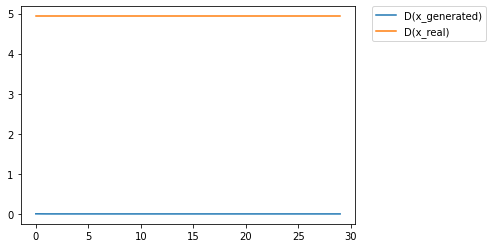

In [20]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()